In [2]:
from random import random, seed, randrange
from math import floor, pi
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import pandas as pd

In [38]:
def load_co( Nco, s_box, N_max ):
    
    Xco = [0]*N_max; Yco =[0]*N_max; Zco =[0]*N_max;
    for i in range(Nco ):
        Xco[i] = random()*s_box #[A]
        Yco[i] = random()*s_box #[A]
        Zco[i] = random()*s_box #[A]
    return Xco, Yco, Zco   

def load_me( Nme, s_box, N_max ):
    
    Xme = [0]*N_max; Yme =[0]*N_max; Zme =[0]*N_max;
    for i in range( Nme ):
        Xme[i] = random()*s_box #[A]
        Yme[i] = random()*s_box #[A]
        Zme[i] = random()*s_box #[A]
    return Xme, Yme, Zme   

def load_c( Nc, s_box):
    Xc = [0]*Nc; Yc =[0]*Nc; Zc =[0]*Nc;
    for i in range( Nme ):
        Xc[i] = random()*s_box #[A]
        Yc[i] = random()*s_box #[A]
        Zc[i] = random()*s_box #[A]
    return Xc, Yc, Zc   

def move(spec, o, x, y, z):
    # Carry out the "move" trial move
    if( spec == "co2"): 
        Xco[o] = x
        Yco[o] = y
        Zco[o] = z
        
    elif (spec == "me"):
        Xme[o] = x
        Yme[o] = y
        Zme[o] = z
    
    
def add(spec, x, y, z):
    # Carry out the "add" trial move
    global Nco, Nme
    if( spec == "co2"): 
        Xco[Nco] = x
        Yco[Nco] = y
        Zco[Nco] = z
        Nco = Nco + 1
        
    elif (spec == "me"):
        Xme[Nme] = x
        Yme[Nme] = y
        Zme[Nme] = z
        Nme = Nme + 1
    
    
def remove(spec, o):
    # Carry out the "remove" trial move
    global Nco, Nme
    if( spec == "co2"): 
        Nco = Nco - 1
        Xco[o] = Xco[Nco]
        Yco[o] = Yco[Nco]
        Zco[o] = Zco[Nco]
        
    elif (spec == "me"):
        Nme = Nme - 1
        Xme[o] = Xme[Nme]
        Yme[o] = Yme[Nme]
        Zme[o] = Zme[Nme]
        
    


def dist_hi(spec,x,y,z,j):
    # Distance btw a proposed particle and the ith H2 particle
    if(spec == "co2"):
        dx = x - Xco[j] #[A]
        dy = y - Yco[j] #[A]
        dz = z - Zco[j] #[A]
    elif (spec == "me"):
        dx = x - Xme[j] #[A]
        dy = y - Yme[j] #[A]
        dz = z - Zme[j] #[A]

    if (dx > 0.5*s_box):
        dx = dx-s_box 
    elif (dx < -0.5*s_box):
        dx = dx + s_box
    if (dy > 0.5*s_box):
        dy = dy-s_box
    elif (dy < -0.5*s_box):
        dy = dy + s_box
    if (dz > 0.5*s_box):
        dz = dz-s_box
    elif (dz < -0.5*s_box):
        dz = dz + s_box
    return dx*dx + dy*dy + dz*dz

def dist_ci(x,y,z,j):
    # Distance btw proposed particle and the ith C particle
    dx = x - Xc[j] #[A]
    dy = y - Yc[j] #[A]
    dz = z - Zc[j] #[A]
    if (dx > 0.5*s_box):
        dx = dx-s_box
    elif (dx < -0.5*s_box):
        dx = dx + s_box
    if (dy > 0.5*s_box):
        dy = dy-s_box
    elif (dy < -0.5*s_box):
        dy = dy + s_box
    if (dz > 0.5*s_box):
        dz = dz-s_box
    elif (dz < -0.5*s_box):
        dz = dz + s_box
    return dx*dx + dy*dy + dz*dz



def Ui(r2, eps, sig):
    # LJ potential btw two particles at r distance away
    if ( r2 < rc*rc ):
        r2i = sig*sig/r2 #[]
        r6i = r2i*r2i*r2i
        ui = 4*eps*(r6i*r6i-r6i) #[K]
        fi = 48*eps*(r6i*r6i-0.5*r6i) #[K]
    else:
        ui = 0
        fi = 0
    return ui, fi

def Up(spec, x, y, z, ia, jb=0):
    # Total LJ potential of proposed particle with all other particles
    # omit the ia'th H2 particle. When not needed, Nh is used.
    # jb used in the UTo operation to avoid overcounting interactions
    U_move = 0
    F_move = 0
    
    if(spec == "co2"):
        #Similar Particles
        for i in range(jb, Nco): # H2 particles
            if ( i != ia):
                r2 = dist_hi("co2", x,y,z, i)
                ui, fi = Ui( r2, e_co, s_co)
                U_move = U_move + ui
                F_move = F_move + fi
        #Other Mobile
        
        for i2 in range(0,Nme):
            r2 = dist_hi("me", x,y,z, i2)
            ui, fi = Ui( r2, e_meco, s_meco)
            U_move = U_move + ui
            F_move = F_move + fi
        
        for ic in range(Nc): # C particles
            r2 = dist_ci( x,y,z, ic)
            ui, fi = Ui( r2, e_cco, s_cco)
            U_move = U_move + ui
            F_move = F_move + fi
        
    elif (spec == "me"):
        #Similar Particles
        for i in range(jb, Nme): # H2 particles
            if ( i != ia):
                r2 = dist_hi("me", x,y,z, i)
                ui, fi = Ui( r2, e_me, s_me)
                U_move = U_move + ui
                F_move = F_move + fi
        #Other Mobile
        
        for i2 in range(0,Nco):
            r2 = dist_hi("co2", x,y,z, i2)
            ui, fi = Ui( r2, e_meco, s_meco)
            U_move = U_move + ui
            F_move = F_move + fi
        
        for ic in range(Nc): # C particles
            r2 = dist_ci( x,y,z, ic)
            ui, fi = Ui( r2, e_cme, s_cme)
            U_move = U_move + ui
            F_move = F_move + fi
                 
    return U_move, F_move

def p_rem(spec, U_move ):
    # Acceptance probability of the "remove" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta < -100):
        return 1
    else:
        if( spec == "c02"):
            return Nco*kb*np.exp( -beta*U_move )/(zz_co*Vol)
        else:
            return Nme*kb*np.exp( -beta*U_move)/(zz_me*Vol)
    
def p_add(spec, U_move ):
    # acceptance probability of the "add" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta > 100):
        return 1
    else:
        if( spec == "co2"):
            return zz_co*Vol*np.exp( -beta*U_move )/(Nco + 1)/kb
        else:
            return zz_me*Vol*np.exp( -beta*U_move )/(Nme + 1)/kb
    
def p_move( U_move ):
    # acceptance probability of the "move" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta < -100):
        return 1
    else:
        return np.exp( -beta*U_move)
    
    
def U_Tot():
    UT = 0
    FT = 0

    # CO2 with CO2
    for j in range( 0, Nco ):
        for i in range( j, Nco):
            if ( i != j ):
                x = Xco[j]; y = Yco[j]; z = Zco[j]
                r2 = dist_hi("co2", x,y,z, i)
                ui, fi = Ui( r2, e_co, s_co)
                UT = UT + ui
                FT = FT + fi
    
    # Me with Me
    for j in range( 0, Nme ):
        for i in range( j, Nme):
            if ( i != j ):
                x = Xme[j]; y = Yme[j]; z = Zme[j]
                r2 = dist_hi("me", x,y,z, i)
                ui, fi = Ui( r2, e_me, s_me)
                UT = UT + ui
                FT = FT + fi

    # CO2 with Me
    for j in range( 0, Nco):
        for i in range( 0, Nme):
            x = Xco[j]; y = Yco[j]; z = Zco[j]
            r2 = dist_hi("me", x,y,z, i)
            ui, fi = Ui( r2, e_meco, s_meco)
            UT = UT + ui
            FT = FT + fi

    # CO2 with C
    for j in range( 0, Nco):
        for i in range( 0, Nc):
            x = Xco[j]; y = Yco[j]; z = Zco[j]
            r2 = dist_ci( x,y,z, i)
            ui, fi = Ui( r2, e_cco, s_cco)
            UT = UT + ui
            FT = FT + fi

    # Me with C
    for j in range( 0, Nme):
        for i in range( 0, Nc):
            x = Xme[j]; y = Yme[j]; z = Zme[j]
            r2 = dist_ci( x,y,z, i)
            ui, fi = Ui( r2, e_cme, s_cme)
            UT = UT + ui
            FT = FT + fi
    
    return( UT, FT )

def box_fix( x, y, z):
    # Correct for unit cell periodicity
    # Currently not used
    if x < 0:
        x = x + s_box
    if x > s_box:
        x = x - s_box
    if y < 0:
        y = y + s_box
    if y > s_box:
        y = y - s_box
    if z < 0:
        z = z + s_box
    if z > s_box:
        z = z - s_box
    return x,y,z


def mc_add():
    global UT, FT, Nco, Nme, Aacc, Aatt
    
    Aatt = Aatt + 1
    
    if ( random() < yco ):
        spec = "co2"
    else:
        spec = "me"
        
    x = random()*s_box
    y = random()*s_box
    z = random()*s_box
    
    U_move, F_move = Up(spec, x, y, z, N_max)
    
    pa_add = p_add(spec, U_move )
    
    if ( random() < pa_add):
        add(spec, x, y, z)
        UT = UT + U_move
        FT = FT + F_move
        Aacc = Aacc + 1
        if ( Nco > N_max | Nme > N_max ):
            stop("Too Many Particles")
            
def mc_remove():
    # Attempt a "remove" trial move
    global UT, FT, Nco, Nme, Ratt, Racc
    Ratt = Ratt + 1
    if (Nco == 0 | Nme == 0):
        return
    
    if ( random() < yco ):
        spec = "co2"
        o = floor( random()*Nco )
        x = Xco[o]
        y = Yco[o]
        z = Zco[o]
    else:
        spec = "me"
        o = floor( random()*Nme )
        x = Xme[o]
        y = Yme[o]
        z = Zme[o]
    
    
    # Calculate Energy of Trial Move
    U_move, F_move = Up(spec, x, y, z, o)
    U_move = -U_move
    F_move = -F_move

    
    # Probability of Accepting Trial Move
    pa_remove = p_rem(spec, U_move )
    
    # Accept or Decline Trial Move
    if (random() < pa_remove):
        remove(spec, o)
        UT = UT + U_move
        FT = FT + F_move
        Racc = Racc + 1
        if ( Nco > N_max | Nme > N_max ):
            stop("Too Many Particles")

def mc_move():
    # Attempt a "move" trial move
    global UT, FT, Nco, Nme, Nacc, Natt
    Natt = Natt + 1
    if (Nco == 0 | Nme == 0):
        return
    
    # Select Random particle
    if ( random() < yco ):
        spec = "co2"
        o = floor( random()*Nco )
        x = Xco[o]
        y = Yco[o]
        z = Zco[o]
    else:
        spec = "me"
        o = floor( random()*Nme )
        x = Xme[o]
        y = Yme[o]
        z = Zme[o]
    
    
    # Calculate Energy of current configuration
    U1, F1 = Up(spec, x,y,z, o)
    
    # Calculate new Location
    xn = x + delta*(random()-0.5)
    yn = y + delta*(random()-0.5)
    zn = z + delta*(random()-0.5)
    xn, yn, zn = box_fix( xn, yn, zn )
    
    # Calculate Energy of New Configuration
    U2, F2 = Up(spec, xn,yn,zn, o)
    U_move = U2 - U1
    F_move = F2 - F1
    
    pa_move = p_move( U_move )
        
    # Accept the trial move
    if ( random() < pa_move ):
        Nacc = Nacc + 1
        move(spec, o, xn, yn, zn)
        UT = UT + U_move
        FT = FT + F_move
        
def sample():
    rho_co = Nco/Vol
    rho_me = Nme/Vol
    Enp = UT/(Nme + Nco)
    Pressure = ( Nco/Vol/beta + Nme/Vol/beta + FT/(3*Vol))*kb*10**(-6)
    return rho_co, rho_me, Enp, Pressure, Nco, Nme

def mc_step():
    # Perform one step of simulation
    if ( random() < pi_move ):
        mc_move()
    else:
        if ( random()< 0.5):
            mc_add()
        else:
            mc_remove()
            
def mc_cycle():
    # perform one cycle of simulation
    global Natt, Nacc, Aatt, Aacc, Ratt, Racc, delta
    rhocow=np.zeros(N_moves); rhomew=np.zeros(N_moves); 
    Enw=np.zeros(N_moves); Pw=np.zeros(N_moves);
    Ncow=np.zeros(N_moves);Nmew=np.zeros(N_moves)
    for i in range(N_moves):
        mc_step()
        rhocow[i], rhomew[i], Enw[i], Pw[i], Ncow[i], Nmew[i] = sample()
    adjust()
    return rhocow.mean(), rhomew.mean(), Enw.mean(), Pw.mean(), Ncow.mean(), Nmew.mean()

def adjust():
    # Change average "move" distance by acceptance history
    # Currently not being used
    global delta, Natt, Nacc
    if (Natt == 0 or Nacc > Natt):
        return
    else:
        frac = Nacc/Natt
        dro = delta
        delta = delta*abs(frac/0.5)
        if (delta/dro > 1.5 ):
            delta = dro*1.5
        if (delta/dro < 0.5):
            delta = dro*0.5
        if (delta > s_box*0.25):
            delta = s_box*0.25
        if (delta < s_box*0.01):
            delta = s_box*0.01
    return

def mc_run():
    # Perform simulation
    global Xco,Yco,Zco,Xme,Yme,Zme,Xc,Yc,Zc,Nc, UT, FT, Natt, Nacc, Aatt, Aacc, Ratt, Racc
    
    # Initialize Unit Cell
    Xco, Yco, Zco = load_co(Nco, s_box, N_max)
    Xme, Yme, Zme = load_me(Nme, s_box, N_max)
    Xc, Yc, Zc = load_c(Nc, s_box)
    UT, FT = U_Tot()
    
    
    # Equilibration Step
    Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0;
    for j in range(N_equil):
        mc_cycle()
        if( (j)%floor(N_equil/10) == 0 ):
            print( j/N_equil )
            Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0 
            

    #Production Step
    rhocov=np.zeros(N_prod); rhomev=np.zeros(N_prod); 
    Env=np.zeros(N_prod); Pv=np.zeros(N_prod);
    Ncov=np.zeros(N_prod); Nmev=np.zeros(N_prod); 
    for j in range(N_prod):
        rhocov[j], rhomev[j], Env[j], Pv[j], Ncov[j], Nmev[j] = mc_cycle()
        if( (j)%floor(N_prod/10) == 0 ):
            print( j/N_prod )
        
    #plt.plot( Pv )
    return (rhocov,rhomev,Env,Pv,Ncov, Nmev)

In [39]:
e_me = 147.9 # eps over kb[K]
s_me = 3.73 # sigma [A]

e_co = 309
s_co = 3.36

e_c = 28.0 #Activated is 89.44
s_c = 3.4

e_meco = np.sqrt(e_me*e_co)
s_meco = (s_me+s_co)/2

e_cme = np.sqrt(e_me*e_c)
s_cme = (s_me+s_c)/2

e_cco = np.sqrt(e_co*e_c)
s_cco = (s_co + s_c)/2

yco = 0.5
P_res = 1000000 #Pa
T = 77 #K
s_box = 20
N_max = 1000
Nco = 3
Nme = 3
Nc = 3
rc = s_box
Vol = s_box**3
beta = 1/T
zz_co = beta*P_res*y_co
zz_me = beta*P_res*(1-y_co)
delta = 1
pi_move = 0.5
kb = 1.3806*10**(7) #[Pa*A^3/K]

N_moves = 100
N_equil = 100
N_prod = 500

rhocov,rhomev,Env,Pv,Ncov, Nmev = mc_run()

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


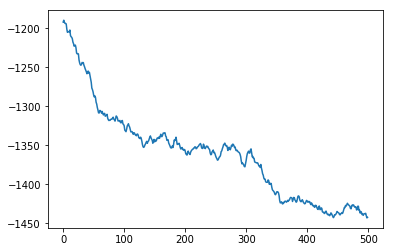

In [44]:
plt.plot( Env )

In [5]:
x = random()*s_box
y = random()*s_box
z = random()*s_box
print("Coords", x, y, z)
add("me", x, y, z )
print( Xme[1:Nme] )

Coords 5.7330109101753095 8.295928021319456 14.95818250376251
[9.200831376781451, 2.438651467786821, 14.750072889370022, 7.02345224021111, 9.86218924282956, 12.386662714834198, 19.10851943795166, 9.534580192231626, 12.93882601057762, 5.7330109101753095]


In [6]:
o = floor( random()*Nco )
print("index", o )
remove("co2", o)
print( Xco[1:Nco])

index 7
[8.849440830889804, 6.255699560681034, 8.278382435620998, 6.749490819500239, 6.036653947260884, 14.674825690806514, 19.587042282744754, 9.767231860561175]


In [7]:
o = floor( random()*Nco )
print("index", o )
x = random()*s_box
y = random()*s_box
z = random()*s_box
print("Coords", x, y, z)
move("co2", o, x, y, z)
print( Xco[1:Nco] )

index 8
Coords 9.580657336890111 17.12478741511213 17.492278543575765
[8.849440830889804, 6.255699560681034, 8.278382435620998, 6.749490819500239, 6.036653947260884, 14.674825690806514, 19.587042282744754, 9.580657336890111]


In [49]:
x = random()*s_box
y = random()*s_box
z = random()*s_box

Up("co2",x,y,z, Nco, 0 )

0
120.74843135664854
-1.0093796403195583
1
86.2451880653975
-2.766140872492022
2
172.5218254509365
-0.34625837338738397


(-21.71982552296159, -129.02269793168438)

-151.75025343275712
-876.7709449932222
